In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.metrics import mean_absolute_error
import sklearn
import os


In [2]:
df=pd.read_csv(r"C:\Users\shami\Downloads\fish_toxicity.csv",sep=";",header=None)

In [3]:
df.columns=['ClC0','SM1_Dz(Z)','GATS1i','NdsCH','NdssC','MLOGP','LC50']

In [4]:
df.head()

,ClC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


# Data Preprocessing and Outlier Removal

In [5]:
# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Check for duplicates
print("Duplicates before cleaning:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)


# Handling outliers using Z-score
X = df.iloc[:, :-1]  # Select all columns except the last one
y = df.iloc[:, -1]   # Select the last column
z_scores = np.abs((X - X.mean()) / X.std())
threshold = 3  # Set the threshold for outliers
outlier_indices = np.where(z_scores > threshold)

# Remove rows containing outliers
X_cleaned = X.drop(outlier_indices[0])
y_cleaned = y.drop(outlier_indices[0])

# Print the number of removed outliers
print("Number of outliers removed:", len(outlier_indices[0]))

# Print the cleaned data
print("Cleaned features:")
print(X_cleaned)
print("Cleaned target variable:")
print(y_cleaned)


# Print summary statistics after cleaning
print("Summary statistics after cleaning:")
print(df.describe())

# Save the cleaned dataset
df.to_csv('cleaned_dataset.csv', index=False)

Missing values before cleaning:
ClC0         0
SM1_Dz(Z)    0
GATS1i       0
NdsCH        0
NdssC        0
MLOGP        0
LC50         0
dtype: int64
Duplicates before cleaning: 1
Number of outliers removed: 36
Cleaned features:
      ClC0  SM1_Dz(Z)  GATS1i  NdsCH  NdssC  MLOGP
0    3.260      0.829   1.676      0      1  1.453
1    2.189      0.580   0.863      0      0  1.348
2    2.125      0.638   0.831      0      0  1.348
3    3.027      0.331   1.472      1      0  1.807
4    2.094      0.827   0.860      0      0  1.886
..     ...        ...     ...    ...    ...    ...
902  3.475      0.405   0.875      1      2  3.148
903  2.801      0.728   2.226      0      2  0.736
905  3.763      0.916   0.878      0      6  2.918
906  2.831      1.393   1.077      0      1  0.906
907  4.057      1.032   1.183      1      3  4.754

[874 rows x 6 columns]
Cleaned target variable:
0      3.770
1      3.115
2      3.531
3      3.510
4      5.390
       ...  
902    4.803
903    3.109
905   

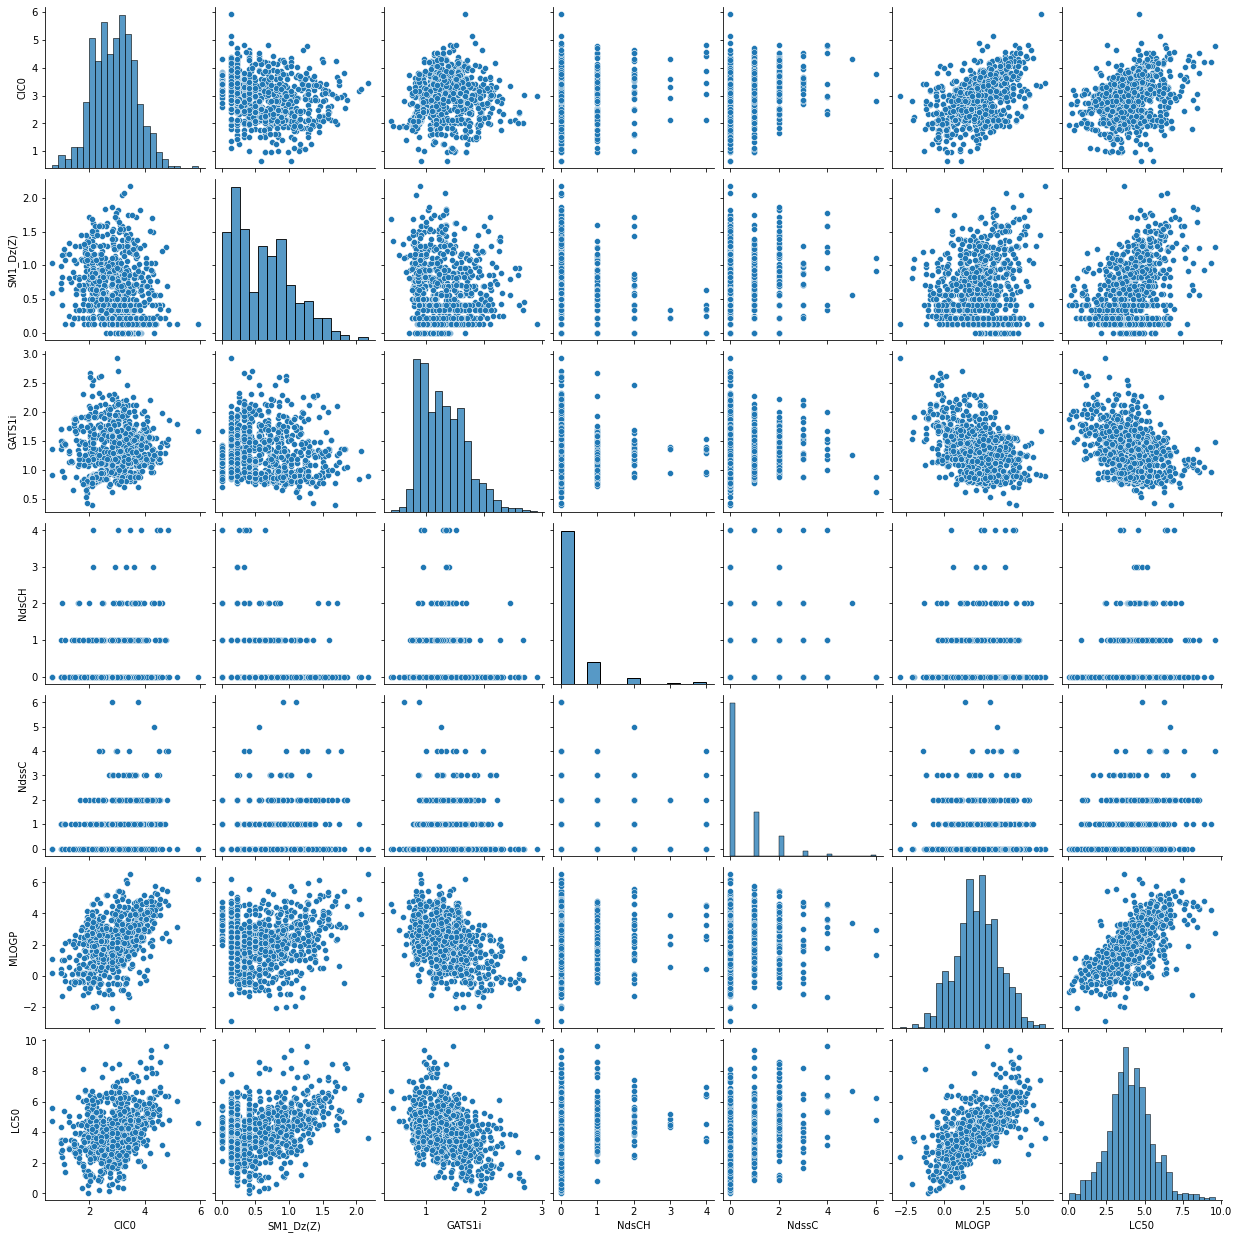

In [6]:
df_cleaned=pd.read_csv(r"C:\Users\shami\cleaned_dataset.csv",sep=",")

sns.pairplot(data=df_cleaned)

In [7]:
df_cleaned.corr(method='pearson')

,ClC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50
ClC0,1.000000,-0.235461,0.147199,0.121153,0.246397,0.463794,0.291799
SM1_Dz(Z),-0.235461,1.000000,-0.146144,-0.141461,0.163138,0.200638,0.410881
GATS1i,0.147199,-0.146144,1.000000,-0.011036,0.091910,-0.451240,-0.398328
NdsCH,0.121153,-0.141461,-0.011036,1.000000,0.187976,0.048507,0.171944
NdssC,0.246397,0.163138,0.091910,0.187976,1.000000,0.028328,0.172310
MLOGP,0.463794,0.200638,-0.451240,0.048507,0.028328,1.000000,0.651648
LC50,0.291799,0.410881,-0.398328,0.171944,0.172310,0.651648,1.000000


LC50 has high positive correlation with MLOGP, positive correlation with SM1_Dz(Z), high negative correlation with GATS1i, and small positive correlation with the rest

<AxesSubplot:xlabel='GATS1i', ylabel='LC50'>

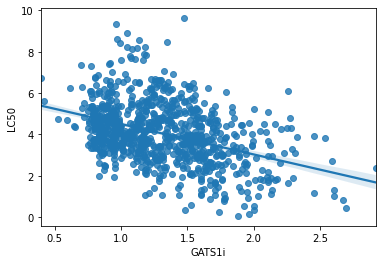

In [8]:
sns.regplot(x=df_cleaned['GATS1i'],y=df_cleaned['LC50'])


In [9]:
df_cleaned.describe()

,ClC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,2.898559,0.628521,1.293980,0.229327,0.486218,2.109735,4.064723
std,0.756394,0.428692,0.394346,0.605621,0.861603,1.433907,1.456475
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.346000,0.223000,0.951000,0.000000,0.000000,1.209000,3.151500
50%,2.937000,0.570000,1.244000,0.000000,0.000000,2.127000,3.991000
75%,3.407000,0.894500,1.562500,0.000000,1.000000,3.105000,4.909000
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


# k-nearest neighbour(KNN)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
plt.style.use('fivethirtyeight')

In [11]:
X = df_cleaned.iloc[:, :6].values
y=df_cleaned.iloc[:,6].values

split  pandas DataFrame df into feature matrix X and target array y.

In [12]:
def KNN():
  return 0

In [13]:
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X_cleaned)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=11)


In [60]:

knn_pred=[]
for k in range(2,10):
  knn=KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train,y_train)
  knn_pred.append(knn.score(X_train,y_train))
  print("R Squared for k: ", k," is ",knn.score(X_train,y_train))


R Squared for k:  2  is  0.8438407632098269
R Squared for k:  3  is  0.7832868677967476
R Squared for k:  4  is  0.7410778164581193
R Squared for k:  5  is  0.7222095427049987
R Squared for k:  6  is  0.7010802181885193
R Squared for k:  7  is  0.6854574823468172
R Squared for k:  8  is  0.6746551697810261
R Squared for k:  9  is  0.6687221403733588


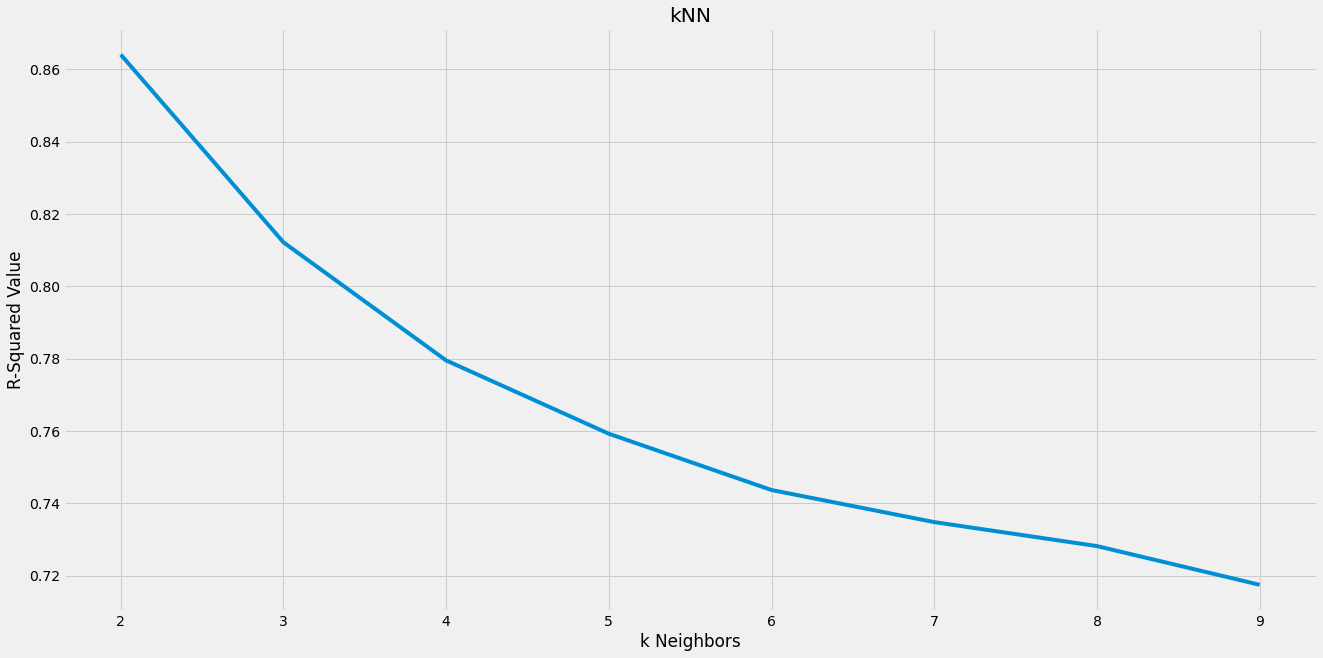

In [16]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(2, 10)], knn_pred)
plt.xlabel('k Neighbors')
plt.ylabel('R-Squared Value')
plt.title('kNN')
plt.show()


In [17]:
knn=KNeighborsRegressor(n_neighbors=2).fit(X_train,y_train)
knn_train_predictions=knn.predict(X_train)
knn_train_rscore = knn.score(X_train,y_train) 
knn_train_rmse=np.sqrt(mean_squared_error(y_train,knn_train_predictions))


In [18]:

knn_test_predictions=knn.predict(X_test)
knn_train_predictions=knn.predict(X_train)
knn_test_rscore=knn.score(X_test,y_test)
knn_train_rscore=knn.score(X_train,y_train)

knn_test_rmse=np.sqrt(mean_squared_error(y_test, knn_test_predictions))
knn_test_mae = mean_absolute_error(y_test, knn_test_predictions)
print("R squared for Testing data: ", knn_test_rscore)

print("Root Mean Squared Error for Testing data: ", knn_test_rmse)
print("Mean Absolute Error for Testing data: ", knn_test_mae)

R squared for Testing data:  0.4045727484969024
Root Mean Squared Error for Testing data:  0.9836316223929711
Mean Absolute Error for Testing data:  0.6925542857142856


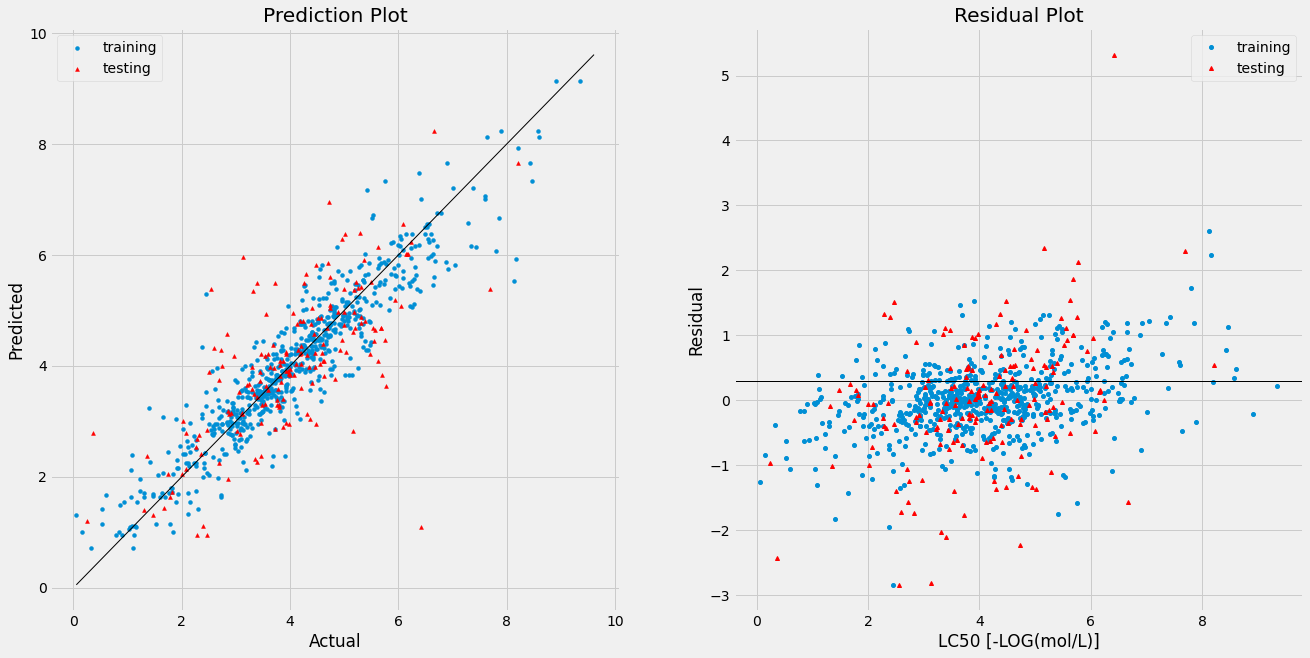

In [19]:
residual_train = y_train - knn_train_predictions
residual_test = y_test - knn_test_predictions

fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(1,2,1)
ax1.scatter(y_train, knn_train_predictions, s=15, label='training')
ax1.scatter(y_test, knn_test_predictions, marker='^', s=15, c='r', label='testing')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=1)
ax1.set_title('Prediction Plot')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.plot(y_train, residual_train, 'o', markersize= 4, label='training')
ax2.plot(y_test, residual_test, '^', c='red', markersize= 4, label='testing')
ax2.axhline(y=0.3, linewidth= 1, linestyle='-', c='black')
ax2.legend()
ax2.set_title('Residual Plot')
ax2.set_xlabel('LC50 [-LOG(mol/L)]')
ax2.set_ylabel('Residual')

plt.show()

# Hyperparameter Tuning

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# Define the hyperparameters grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters and model accuracy
print("Best Hyperparameters:", best_params)

#Fit the best Model on training set

best_model.fit(X_train, y_train)

#Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_train= best_model.predict(X_train)

# Evaluate the model performance
r2 = r2_score(y_test, y_pred)
r2_train=r2_score(y_train,y_pred_train)
mse_new = mean_squared_error(y_test, y_pred)



print("R2 for test set", r2)
print("MSE for test set", mse_new)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score



Best Hyperparameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
R2 for test set 0.6481161999542233
MSE for test set 0.7143919675617099


# MULTIPLE LINEAR REGRESSION

In [21]:
from sklearn.linear_model import LinearRegression


In [22]:
X=df_cleaned.iloc[:,:-1].values
y=df_cleaned.iloc[:,6].values

In [23]:
X_train,X_test,y_train,y_test= train_test_split(X_cleaned,y_cleaned,test_size=0.2,random_state=42)


In [24]:
mlr=LinearRegression()
mlr.fit(X_train,y_train)
mlr_train_rscore=mlr.score(X_train,y_train)
mlr_train_pred=mlr.predict(X_train)
mlr_train_rmse=np.sqrt(mean_squared_error(y_train,mlr_train_pred))

In [25]:
print("R squared for Training data: ", mlr_train_rscore)
print("Root Mean Squared Error for Training data: ", mlr_train_rmse)


R squared for Training data:  0.5617748153883653
Root Mean Squared Error for Training data:  0.9501232424349191


In [26]:
mlr_test_rscore=mlr.score(X_test,y_test)
mlr_test_pred=mlr.predict(X_test)
mlr_test_rmse=np.sqrt(mean_squared_error(y_test,mlr_test_pred))
mlr_test_mae=mean_absolute_error(y_test,mlr_test_pred)
mlr_test_rscore1 = r2_score(y_test, mlr_test_pred)




In [27]:
def MLR():
  return {'Regressor Model':'Multiple Linear Regression',
          'Predictions':mlr_test_pred,
          'R Squared': mlr_test_rscore,
          'Mean Absolute Error':mlr_test_mae,
          'Root Mean Squared Error':mlr_test_rmse,
          'Training Time': training_time_mlr,
          'Prediction Time':testing_time_mlr}

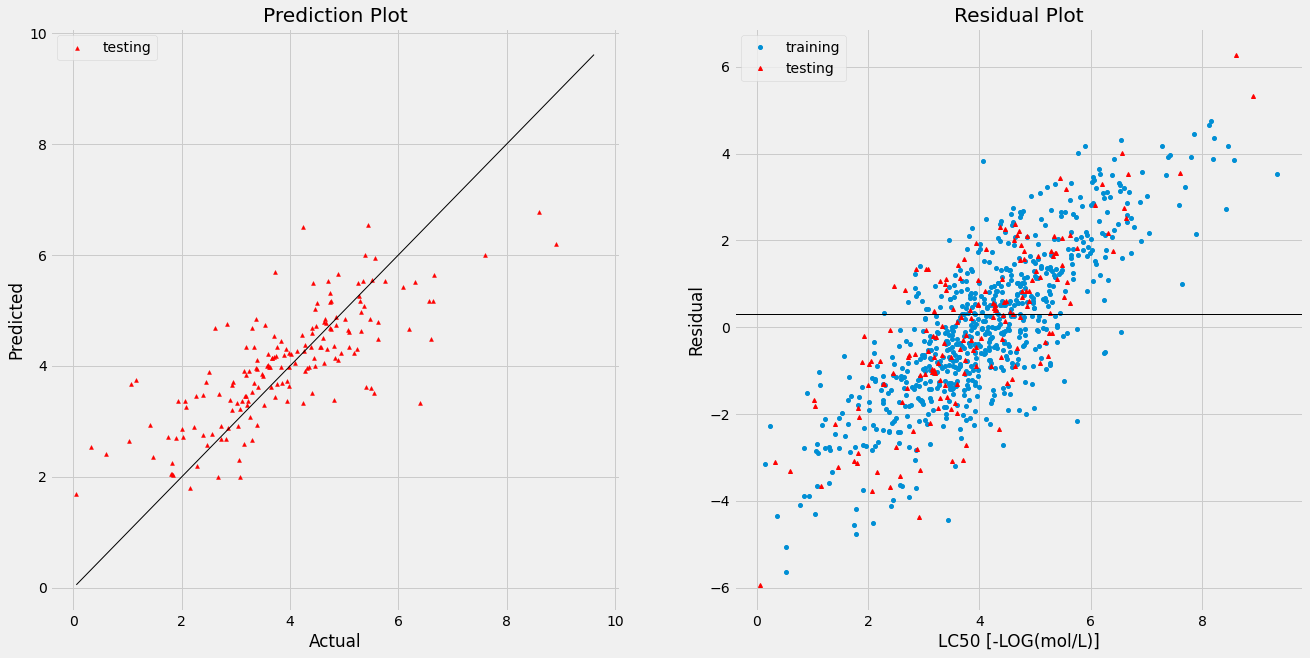

In [74]:
residual_train = y_train - mlr_train_pred
residual_test = y_test - mlr_test_pred

fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(1,2,1)
#ax1.scatter(y_train, mlr_train_pred, s=15, label='training')
ax1.scatter(y_test, y_pred, marker='^', s=15, c='r', label='testing')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=1)
ax1.set_title('Prediction Plot')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.plot(y_train, residual_train, 'o', markersize= 4, label='training')
ax2.plot(y_test, residual_test, '^', c='red', markersize= 4, label='testing')
ax2.axhline(y=0.3, linewidth= 1, linestyle='-', c='black')
ax2.legend()
ax2.set_title('Residual Plot')
ax2.set_xlabel('LC50 [-LOG(mol/L)]')
ax2.set_ylabel('Residual')

plt.show()

# Hyperparameter Tuning using Randomized Grid Search

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import uniform
# Define the hyperparameters distributions for tuning
param_distributions = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, None]
}
linear_regression = LinearRegression()

# Perform randomized search with cross-validation
randomized_search = RandomizedSearchCV(estimator=linear_regression, param_distributions=param_distributions,
                                       n_iter=10, cv=5, random_state=42)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(),
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'n_jobs': [-1, None],
                                        'normalize': [True, False]},
                   random_state=42)

In [79]:
# Fit the model to the training data
linear_regression.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_regression.predict(X_test)

# Evaluate the model using R-squared
mlr_test_rscore2=linear_regression.score(X_test,y_pred)
mse = mean_squared_error(y_test, y_pred_test)
print("Rscore for test data:" ,mlr_test_rscore2)
print("MSE for test data:" ,mse)




#Excellent Rscore of 1 obtained after hyperparameter tuning



Rscore for test data: 1.0
MSE for test data: 0.8495873521505297


# Hyperparameter Tuning using gridsearch

In [72]:

# Create the GridSearchCV object
grid_search = GridSearchCV(linear_regression, param_grid, cv=5, scoring='r2')
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1]
}


# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test data
y_pred_test = best_model.predict(X_test)

# Calculate the R2 score for the test data
test_r2_score = r2_score(y_test, y_pred_test)

# Print the best hyperparameters and the test R2 score
print("Best Hyperparameters:", best_params)
print("Test R2 Score:", test_r2_score)


Best Hyperparameters: {'fit_intercept': True, 'normalize': False}
Test R2 Score: 0.5815238139281937


# SVM REGRESSOR

In [31]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [32]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_cleaned)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_cleaned,test_size=0.2,shuffle=True, random_state=44)


In [73]:

clf=svm.SVR(C=1,gamma=0.1)
clf.fit(X_train,y_train)


SVR(C=1, gamma=0.1)

In [35]:
clf_train_rscore=clf.score(X_train,y_train)
clf_train_pred=clf.predict(X_train)
clf_train_rmse=np.sqrt(mean_squared_error(y_train,clf_train_pred))

In [36]:
print("R squared for Training data: ",clf_train_rscore)
print("Root Mean Squared Error for Training data: ", clf_train_rmse)

R squared for Training data:  0.7021386460979472
Root Mean Squared Error for Training data:  0.7693620823764448


In [37]:
clf_test_rscore=clf.score(X_test,y_test)
clf_test_pred=clf.predict(X_test)
clf_test_rmse=np.sqrt(mean_squared_error(y_test,clf_test_pred))
clf_test_mae=mean_absolute_error(y_test,clf_test_pred)

In [38]:
print("R squared for Testing data: ", clf_test_rscore)
print("Root Mean Squared Error for Testing data: ", clf_test_rmse)
print("Mean Absolute Error for Testing data: ", clf_test_mae)

R squared for Testing data:  0.5930434816416116
Root Mean Squared Error for Testing data:  0.9695640987283272
Mean Absolute Error for Testing data:  0.6768816129266453


In [39]:
def SVM():
  return {'Regressor Model':'SVM Regressor',
          'Predictions':clf_test_pred,
          'R Squared': clf_test_rscore,
          'Mean Absolute Error':clf_test_mae,
          'Root Mean Squared Error':clf_test_rmse,
          }

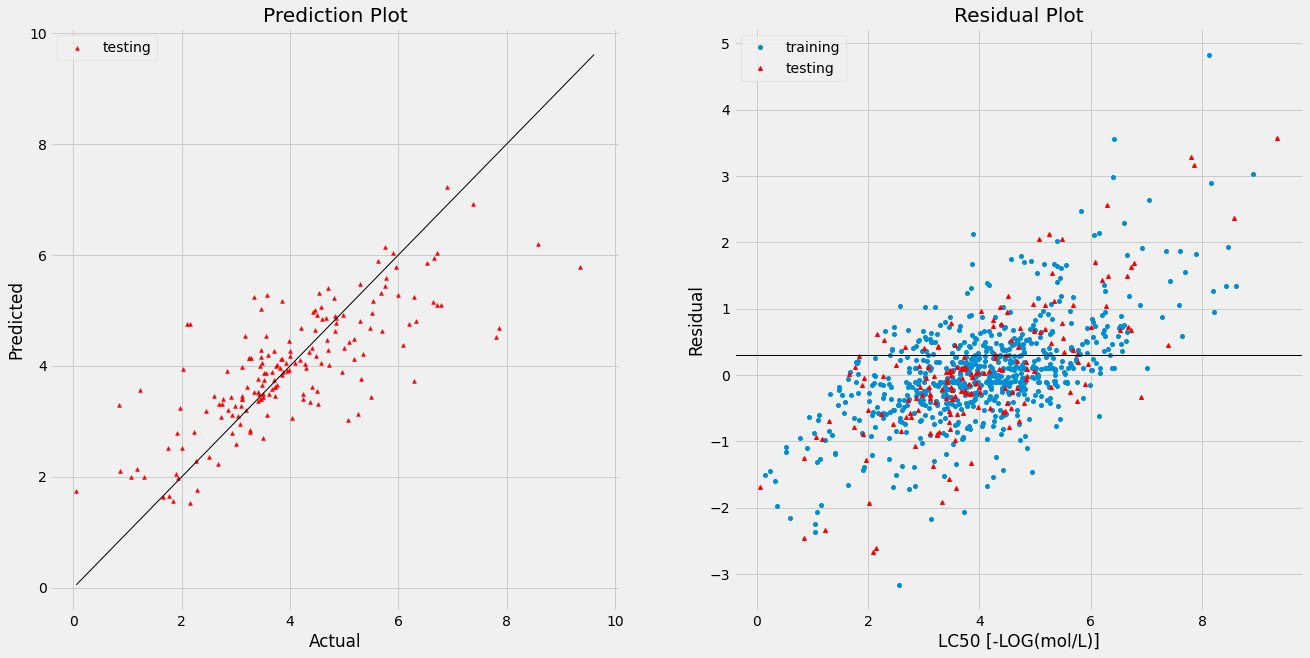

In [40]:
residual_train = y_train - clf_train_pred
residual_test = y_test - clf_test_pred

fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(1,2,1)
#ax1.scatter(y_train, clf_train_pred, s=15, label='training')
ax1.scatter(y_test, clf_test_pred, marker='^', s=15, c='r', label='testing')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=1)
ax1.set_title('Prediction Plot')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.plot(y_train, residual_train, 'o', markersize= 4, label='training')
ax2.plot(y_test, residual_test, '^', c='red', markersize= 4, label='testing')
ax2.axhline(y=0.3, linewidth= 1, linestyle='-', c='black')
ax2.legend()
ax2.set_title('Residual Plot')
ax2.set_xlabel('LC50 [-LOG(mol/L)]')
ax2.set_ylabel('Residual')

plt.show()

# Hyperparameter Tuning

In [80]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Create an SVM regressor object
svr = SVR()

# Define the parameter grid for grid search
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best SVM regressor model
best_svr = grid_search.best_estimator_

# Make predictions on the test data
y_pred_test = best_svr.predict(X_test)
y_pred_train=best_svr.predict(X_train)

# Calculate the R2 score for the test data
svr_test_rscore = r2_score(y_test, y_pred_test)
svr_train_rscore= r2_score(y_train,y_pred_train)
mse_svm=mean_squared_error(y_train,y_pred_train)


# Print the best hyperparameters and R2 score
print("Best Hyperparameters:", grid_search.best_params_)
print("R2 Score (Test):", svr_test_rscore)
print("R2 Score (Train):",svr_train_rscore)
print("MSE (Train):",mse_svm)



Best Hyperparameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
R2 Score (Test): 0.6335707332792679
R2 Score (Train): 0.7116430946843951
MSE (Train): 0.5907930607530008


In [42]:
tuned_test_rmse=np.sqrt(mean_squared_error(y_test,y_pred_test))
tuned_test_mae=mean_absolute_error(y_test,y_pred_test)
print(tuned_test_mae)
print(tuned_test_rmse)

0.7049909554101591
0.9854645143850964


# Random Forest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
X_train,X_test,y_train,y_test = train_test_split(X_cleaned,y_cleaned,test_size=0.2,random_state=66)
rf=RandomForestRegressor(max_depth=6,max_features=0.4).fit(X_train,y_train)
rf_train_rscore=rf.score(X_train,y_train)
rf_train_pred=rf.predict(X_train)
rf_train_rmse=np.sqrt(mean_squared_error(y_train,rf_train_pred))
print("R squared for Training data: ",rf_train_rscore)
print("Root Mean Squared Error for Training data: ", rf_train_rmse)

R squared for Training data:  0.7749190710686439
Root Mean Squared Error for Training data:  0.6790814452152153


In [53]:
rf_test_rscore=rf.score(X_test,y_test)
rf_test_pred=rf.predict(X_test)
rf_test_rmse=np.sqrt(mean_squared_error(y_test,rf_test_pred))
rf_test_mae=mean_absolute_error(y_test,rf_test_pred)
print("R squared for Testing data: ",rf_test_rscore)
print("Root Mean Squared Error for Testing data: ", rf_test_rmse)
print("Mean Absolute Error for Testing data: ", rf_test_mae)

R squared for Testing data:  0.5876982395648757
Root Mean Squared Error for Testing data:  0.9149055019500976
Mean Absolute Error for Testing data:  0.6594108693544246


In [54]:
def RF():
  return {'Regressor Model':'Random Forest Regressor',
          'Predictions':rf_test_pred,
          'R Squared': rf_test_rscore,
          'Mean Absolute Error':rf_test_mae,
          'Root Mean Squared Error':rf_test_rmse,
          }

In [55]:
def value(n):
    x=clf.predict(n)
    return x
value([[3.59, 0.43, 1.38, 0.  , 2.  , 1.97]])[0]

5.281497768419157

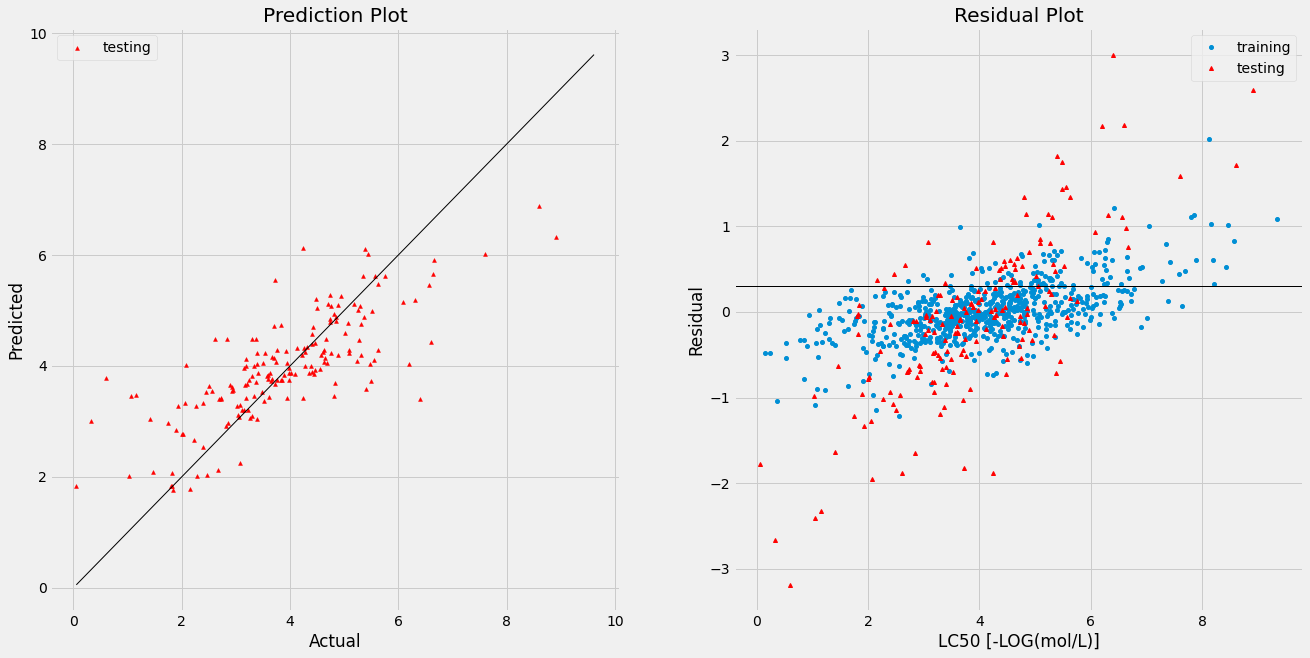

In [82]:
residual_train = y_train - y_pred_train
residual_test = y_test - rf_test_pred

fig=plt.figure(figsize=(20,10))

ax1=plt.subplot(1,2,1)
#ax1.scatter(y_train, rf_train_pred, s=15, label='training')
ax1.scatter(y_test, rf_test_pred, marker='^', s=15, c='r', label='testing')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=1)
ax1.set_title('Prediction Plot')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.plot(y_train, residual_train, 'o', markersize= 4, label='training')
ax2.plot(y_test, residual_test, '^', c='red', markersize= 4, label='testing')
ax2.axhline(y=0.3, linewidth= 1, linestyle='-', c='black')
ax2.legend()
ax2.set_title('Residual Plot')
ax2.set_xlabel('LC50 [-LOG(mol/L)]')
ax2.set_ylabel('Residual')

plt.show()

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

# Create a Random Forest Regressor model
rf = RandomForestRegressor()

# Define the parameter distribution for randomized search
param_distribution = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distribution, cv=5)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Get the best Random Forest Regressor model
best_rf = random_search.best_estimator_

# Make predictions on the test data
y_pred_test = best_rf.predict(X_test)
y_pred_train= best_rf.predict(X_train)

# Calculate the R2 score for the test data
rf_test_rscore_best = r2_score(y_test, y_pred_test)
rf_train_score_best= r2_score(y_train,y_pred_train)
rf_mse=mean_squared_error(y_train,y_pred_train)

# Print the best hyperparameters and R2 score
print("Best Hyperparameters:", random_search.best_params_)
print("R2 Score (Test):", rf_test_rscore_best)
print("R2 Score (Train):", rf_train_score_best)
print("MSE (Train):", rf_mse)




Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
R2 Score (Test): 0.6175326386535844
R2 Score (Train): 0.946149878685309
MSE (Train): 0.11032951667519875


Best model after hyperparameter tuning improved r2 score for both training and test dataset